In [2]:
# Packages for analysis
import pandas as pd
import numpy as np
from numpy import dtype
from netCDF4 import Dataset,date2num,num2date
from datetime import datetime
import pickle

# Packages for visuals
import matplotlib.pyplot as plt

# Allows charts to appear in the notebook
%matplotlib inline

import pyart
import numpy.ma as ma
import matplotlib.ticker as mticker
from matplotlib import colors as c
from matplotlib.colors import ListedColormap,BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.geodesic as cargeo
from shapely.geometry import Polygon
import os
import warnings
warnings.filterwarnings('ignore')

### Load model SVM

In [3]:
model = pickle.load(open("A3/SVM_model_file_b4.pkl", "rb"))

In [4]:
class UF:
    def __init__(self,radar,shape_grid,lat_0, lon_0):
        self.radar = radar
        self.shape_grid = shape_grid
        self.lat_0 = lat_0
        self.lon_0 = lon_0
    def calculate_attenuation_zphi(self):
        fixed_fzl=3000
        spec_at, pia_dict, cor_z, spec_diff_at, pida_dict, cor_zdr= pyart.correct.calculate_attenuation_zphi(
            self.radar,
            refl_field='reflectivity', 
            phidp_field= 'differential_phase',
            zdr_field='differential_reflectivity',
            temp_ref='fixed_fzl')
        return cor_z,cor_zdr
    def remove_noises(self):
        mask_noises_CC=ma.masked_less(self.radar.fields['cross_correlation_ratio']['data'],0.85)
        mask_noises_Z=ma.masked_less(self.radar.fields['reflectivity']['data'],0)
        mask_noises_KDP=ma.masked_less_equal(self.radar.fields['specific_differential_phase']['data'],0)
        rm_noises_Z_=np.ma.masked_array(self.radar.fields['reflectivity']['data'],mask_noises_CC.mask)
        rm_noises_Z=np.ma.masked_array(rm_noises_Z_,mask_noises_Z.mask)
        rm_noises_ZDR_=np.ma.masked_array(self.radar.fields['differential_reflectivity']['data'],mask_noises_CC.mask)
        rm_noises_ZDR=ma.masked_array(rm_noises_ZDR_,mask_noises_Z.mask)
        rm_noises_KDP_=np.ma.masked_array(self.radar.fields['specific_differential_phase']['data'],mask_noises_CC.mask)
        #rm_noises_KDP_Z=ma.masked_array(rm_noises_KDP_,mask_noises_Z.mask)
        rm_noises_KDP=ma.masked_array(rm_noises_KDP_,mask_noises_KDP.mask)
        self.radar.add_field_like('reflectivity','Z_removed_noises',rm_noises_Z,replace_existing=True)
        self.radar.add_field_like('differential_reflectivity','ZDR_removed_noises', rm_noises_ZDR,replace_existing=True)
        self.radar.add_field_like('specific_differential_phase','KDP_removed_noises', rm_noises_KDP,replace_existing=True)
    def convert_grid(self):
        grid = pyart.map.grid_from_radars(
            self.radar,
            grid_shape=self.shape_grid, #Number of points in the grid (z, y, x)
            grid_limits=((0, 9000), (-200000, 200000), (-200000, 200000)), # min-max tuong duong z,y,x
            grid_origin = (self.lat_0, self.lon_0),
            fields=['Z_removed_noises',
                    'ZDR_removed_noises',
                    'KDP_removed_noises',
                    ],
            roi_func='dist_beam',
            weighting_function='cressman')
        return grid
    def convert_lat_lon(self, grid):
        #conver distance to lat/lon
        for i in range(self.shape_grid[1]):
            geog = pyart.core.cartesian_to_geographic_aeqd(grid.x["data"][i],grid.y["data"][i],self.lon_0, self.lat_0, R=6370997.0)
            grid.x["data"][i] = geog[0]
            grid.y["data"][i] = geog[1]
        return grid
    def SHY95_algorithm(self,Zh):
        Zh.mask=0
        SHY95=np.zeros((self.shape_grid[1],self.shape_grid[2]))
        #Step 1: Intensity
        mask_st1=(Zh>=40)
        SHY95[mask_st1]=1
        #Step 2: Peakeness
        def MBG(xo,yo,n,r,Zh): #Mean Background Reflectivity
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            Zh_none_O=Zh[xo,yo]
            Zbg_ = np.ma.masked_array(Zh[mask], Zh[mask] ==Zh_none_O) # remove value cycle centers
            Zbg = np.ma.masked_array(Zbg_, Zbg_ == 0) # remove 0 values
            return Zbg
        for xo in range (0,self.shape_grid[1],1):
            for yo in range (0,self.shape_grid[2],1):
                if SHY95[xo,yo]==0:
                    Zbg=MBG(xo,yo,self.shape_grid[1],5.5,Zh).mean()
                    deltaZh=Zh[xo,yo]-Zbg
                    if (Zbg < 42.43) and (deltaZh >= (10-Zbg**2/180)):
                        SHY95[xo,yo]=1
                    elif Zbg>=42.43 and deltaZh>=0:
                        SHY95[xo,yo]=1
        #Step3: Surrounding area
        def MBG_mask_r(xo,yo,n,r,): # mask array with r change
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            return mask
        medium=[25,30,35,40]
        for xo in range (0,self.shape_grid[1],1):
            for yo in range (0,self.shape_grid[2],1):
                if SHY95[xo,yo]==1:
                    Zbg=MBG(xo,yo,self.shape_grid[1],5.5,Zh).mean()
                    if Zbg < medium[0]:
                        r=0.5 #1km
                    elif Zbg>=medium[0] and Zbg <medium[1]:
                        r=1   #2km
                    elif Zbg>=medium[1] and Zbg <medium[2]: 
                        r=1.5 #3km
                    elif Zbg>=medium[2] and Zbg <medium[3]:
                        r=2   #4km
                    elif Zbg>=medium[3]:
                        r=2.5 #5km
                    mask_st2=MBG_mask_r(xo,yo,self.shape_grid[1],r=r)
                    SHY95[mask_st2]=2
        #Step4: remaining areas as stratiform
        for q in range (0,self.shape_grid[1],1):
            for l in range (0,self.shape_grid[2],1):
                if Zh[q,l] > 0 and SHY95[q,l] !=2:
                    SHY95[q,l]=1
        SHY95=ma.masked_equal(SHY95,0)
        return SHY95
    def SVM_algorithm(self,model,Zh_SVM,ZDR_SVM):
        SVM=np.zeros((shape_grid[1],shape_grid[2]))
        for xo in range (0,shape_grid[1],1):
            for yo in range (0,shape_grid[2],1):
                if Zh_SVM[xo,yo]!='masked' and ZDR_SVM[xo,yo]!='masked':
                    resuls=model.predict([[Zh_SVM[xo,yo], ZDR_SVM[xo,yo]]])
                    if resuls==2.0:
                        SVM[xo,yo]=2
                    elif resuls==1.0:
                        SVM[xo,yo]=1
        SVM=ma.masked_equal(SVM,0)
        return SVM
    def create_nc(self, fileout, SVM,Zh_SVM,ZDR_SVM,KDP_SVM,grid,format_time):
        file = Dataset(fileout,'w')
        file.title = "SVM Algorithm files - netCDF "
        file.createDimension('longitude',self.shape_grid[2])
        file.createDimension('latitude',self.shape_grid[1])
        file.createDimension('time',1)
        times = file.createVariable('time',dtype('i8').char,('time',))
        lons = file.createVariable('longitude',dtype('f4').char,('longitude',))
        lats = file.createVariable('latitude',dtype('f4').char,('latitude',))
        lats.units = 'degrees_north'
        lats.standard_name = "Latitude"
        lats.long_name = "Latitude"
        lats.axis = "Y"
        lons.standard_name = "Longitude"
        lons.long_name = "Longitude"
        lons.axis = "X"
        lons.units = 'degrees_east'
        times.units = "minutes since 2000-01-01 00:00"
        times.calendar = "gregorian"
        times.standard_name = "time"
        times.axis = "T"
        lons[:] = grid.x["data"]
        lats[:] = grid.y["data"]
        times[:] = date2num(format_time,units=times.units,calendar=times.calendar)
        Alg_SVM = file.createVariable('CS_SVM',dtype('f4').char,('time','latitude','longitude'))
        Alg_SVM.units = 'C/S'
        Alg_SVM[:] = SVM
        #Alg_SHY95 = file.createVariable('CS_SHY95',dtype('f4').char,('time','latitude','longitude'))
        #Alg_SHY95.units = 'C/S'
        #Alg_SHY95[:] = SHY95
        Alg_Zh = file.createVariable('Zh_1.5km',dtype('f4').char,('time','latitude','longitude'))
        Alg_Zh.units = 'dBZ'
        Alg_Zh[:] = Zh_SVM
        Alg_ZDR = file.createVariable('ZDR_1.5km',dtype('f4').char,('time','latitude','longitude'))
        Alg_ZDR.units = 'dB'
        Alg_ZDR[:] = ZDR_SVM
        Alg_KDP = file.createVariable('KDP_1.5km',dtype('f4').char,('time','latitude','longitude'))
        Alg_KDP.units = 'dB'
        Alg_KDP[:] = KDP_SVM
        file.close()
#Tạo giới hạn bán kính 200km    
y,x = np.ogrid[-100:201-100, -100:201-100]
mask = x*x + y*y > 100*100

In [12]:
#Testing-Embedded:1,2,8,9,10,12,13,14,15/Full stratiform:1,6,7,8,10,12,13,14,15/Squall line:2,6,7,9,10,12,13,14,15
Case='Full stratiform'
Case_dic={Case:[16,17,18,19]}
for r in Case_dic[Case]:
    linkRAW='D:/data/Radars/'+Case+'/'+str(r)+'/'
    print(linkRAW)
    os.mkdir('D:/data/SVM_netCDF2/'+Case+'/'+str(r))
    linkOUT='D:/data/SVM_netCDF2/'+Case+'/'+str(r)+'/'
    for file_name in os.listdir(linkRAW):
        radar = pyart.io.read_sigmet(linkRAW+file_name)
        lat_0 = radar.latitude['data'][0]
        lon_0 = radar.longitude['data'][0]
        shape_grid = (7, 201,201)
        UF_File = UF(radar, shape_grid, lat_0, lon_0)
        UF_File.remove_noises()
        grid = UF_File.convert_grid()
        grid_lat_lon = UF_File.convert_lat_lon(grid)
        Zh_SVM=np.ma.masked_array(grid.fields['Z_removed_noises']['data'][1,:,:],mask)
        ZDR_SVM=np.ma.masked_array(grid.fields['ZDR_removed_noises']['data'][1,:,:],mask)
        KDP_SVM=np.ma.masked_array(grid.fields['KDP_removed_noises']['data'][1,:,:],mask)
        SVM=UF_File.SVM_algorithm(model,Zh_SVM,ZDR_SVM)
        #SHY95=np.ma.masked_array(UF_File.SHY95_algorithm(grid.fields['Z_removed_noises']['data'][1,:,:]),mask)
        format_string_time = "%Y-%m-%dT%H:%M"
        ti=radar.time['units'][14:-4]
        format_time=datetime.strptime(ti, format_string_time)
        UF_File.create_nc(linkOUT+"SVM"+file_name[3:15]+".nc", SVM, Zh_SVM,ZDR_SVM,KDP_SVM,grid_lat_lon,format_time)
        print(file_name)

D:/data/Radars/Full stratiform/16/
PHA220505191004.RAW9TF8
PHA220505192004.RAW9TFH
PHA220505193004.RAW9TFT
PHA220505194004.RAW9TG2
PHA220505195004.RAW9TGB
PHA220505200004.RAW9TGL
PHA220505201004.RAW9TGW
PHA220505202004.RAW9TH5
PHA220505203004.RAW9THE
PHA220505204004.RAW9THP
PHA220505205004.RAW9THZ
PHA220505210004.RAW9TJ8
PHA220505211004.RAW9TJH
PHA220505212003.RAW9TJT
PHA220505213004.RAW9TK2
PHA220505214004.RAW9TKB
PHA220505215004.RAW9TKL
PHA220505220004.RAW9TKW
PHA220505221004.RAW9TL5
PHA220505222005.RAW9TLE
PHA220505223003.RAW9TLP
PHA220505224004.RAW9TLZ
PHA220505225004.RAW9TM8
PHA220505230004.RAW9TMH
D:/data/Radars/Full stratiform/17/
PHA220521161004.RAWACBP
PHA220521162004.RAWACBZ
PHA220521163004.RAWACC8
PHA220521164005.RAWACCH
PHA220521165004.RAWACCT
PHA220521170004.RAWACD2
PHA220521171004.RAWACDB
PHA220521172004.RAWACDL
PHA220521173004.RAWACDW
PHA220521174004.RAWACE5
PHA220521175004.RAWACEE
PHA220521180004.RAWACEP
PHA220521181004.RAWACEZ
PHA220521182004.RAWACF8
PHA220521183004.RA

In [11]:
# Draw Range_Rings
circle_points_50km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=50000, n_samples=180, endpoint=False)
circle_points_100km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=100000, n_samples=180, endpoint=False)
circle_points_200km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=200000, n_samples=180, endpoint=False)
geom_50km=Polygon(circle_points_50km)
geom_100km=Polygon(circle_points_100km)
geom_200km=Polygon(circle_points_200km)

In [8]:
# Read file netCDF and prepare datas to plot
data=Dataset(r'E:/SVM_netCDF/Embedded/1/SVM210405091004.nc','r')
lon=data.variables['longitude'][:]
lat=data.variables['latitude'][:]
lons,lats=np.meshgrid(lon,lat)
pre=data.variables['CS_SVM'][:][0,:,:].filled(fill_value=0.0)

In [11]:
np.log(pre[1,1])

-inf

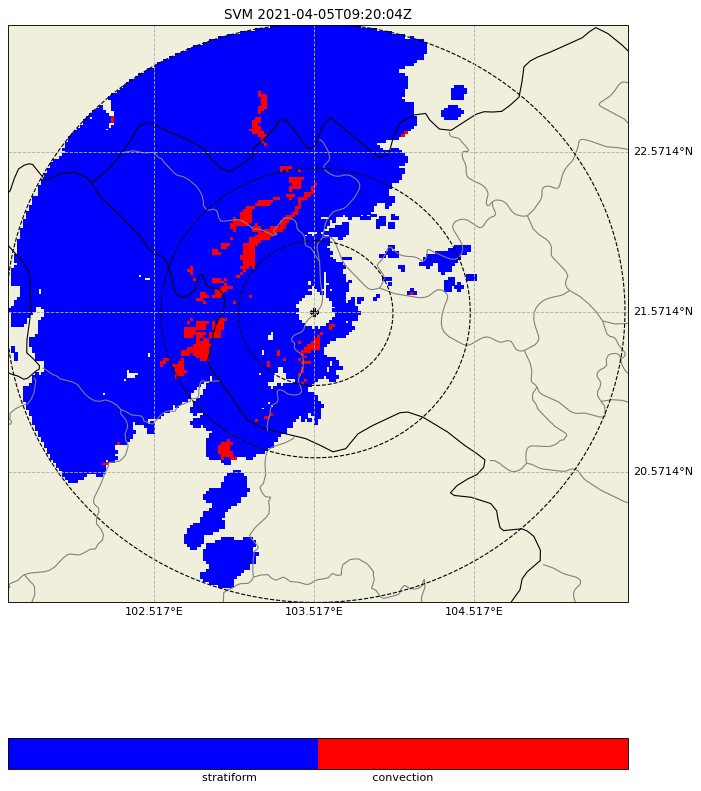

In [13]:
fig=plt.figure(figsize=(10,15),dpi=80)
ax1=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeat.LAND)
ax1.add_feature(cfeat.OCEAN.with_scale('10m'))
ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax1.add_feature(state_provinces_lines,edgecolor='gray')
g1=ax1.gridlines(draw_labels=True,linestyle='--')
g1.xlabels_top = False
g1.ylabels_left = False
g1.xlocator = mticker.FixedLocator([102.51694002747536, 103.51694002747536, 104.51694002747536, 105.51694002747536])
g1.ylocator = mticker.FixedLocator([20.571390070021152,21.571390070021152,22.571390070021152])
ax1.set_extent((grid.x['data'][0],grid.x['data'][-1],grid.y['data'][0],grid.y['data'][-1]),crs=ccrs.PlateCarree())
ax1.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
cMap = c.ListedColormap(['b','r'])
z1_plot=ax1.pcolormesh(lons,lats,pre,shading='flat',cmap=cMap)
ax1.scatter(x=103.51694002747536,y=21.571390070021152,transform=ccrs.PlateCarree(), color="black",s=50, alpha=1,marker='P')
ax1.set(title="SVM "+ radar.time['units'][14:])
plt.colorbar(z1_plot,ax=ax1,orientation='horizontal',ticks=[], label='stratiform                                 convection');

In [23]:
data.variables['Zh_1.5km'][:][0,:,:].min()

0.04